In [3779]:
import pandas as pd
import numpy as np
import math as mt

import tensorflow as tf
from tensorflow.python.framework import ops

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

import xgboost

from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3780]:
# Load House train data
train = pd.read_csv('train.csv')

In [3781]:
# Put the labels aside
labels_orig = train.SalePrice.as_matrix().reshape(-1, 1)

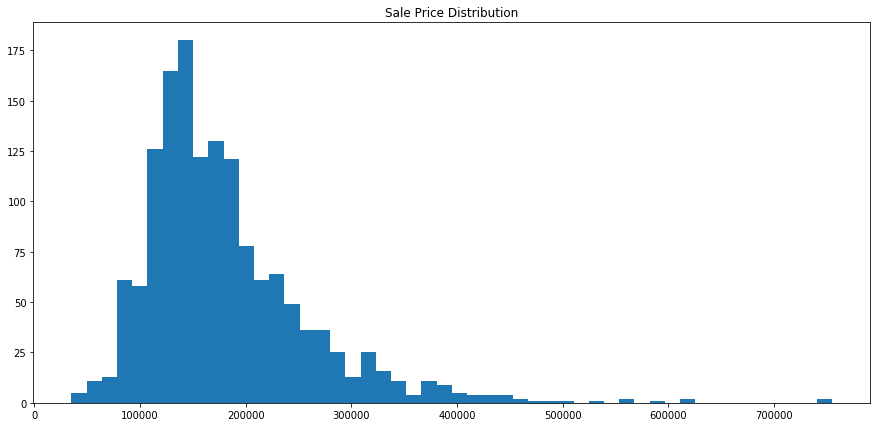

In [3782]:
# Посмотрим на гистограмму цен
#plt.subplot(1, 2, 2)
plt.figure(figsize=(15, 7))
plt.hist(train.SalePrice, bins=50)
#plt.ylabel('Mean Absolute Error')
#plt.xlabel('Iterations')
plt.title("Sale Price Distribution")

plt.show() 

In [3783]:
# Which columns have NaN values?
count = 0

for col in train.columns:
    if(train[col].isnull().sum() > 0):
        print(col)
        count = count + 1
        
print("Total", count, "columns with NaNs")

LotFrontage
Alley
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature
Total 19 columns with NaNs


In [3784]:
# Поиграем с NaN еще раз
#train[train.GarageType.isnull()][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].sum().sum()
#train[train.FireplaceQu.isnull()][['Fireplaces', 'FireplaceQu']].sum().sum()
#train[train.BsmtExposure.isnull()][['Id', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']] #.sum().sum()
#train[train.MasVnrType.isnull()][['MasVnrType', 'MasVnrArea']] #.sum().sum()
#train[train.Alley.isnull()][['LotFrontage', 'Alley']] #.sum().sum()

In [3785]:
#train = train[train.YrSold != 2008]

In [3786]:
# Define variables
cols = []
cols_count = 0

# Делать предсказания по наиболее коррелирующим фичам
use_fe_1 = False
fe_1_cols = []

# Handling years as categorial 
use_fe_2 = True

# Using kind of a total sum of square feet
use_fe_3 = True

# Using new feature of Clustering
use_fe_4 = True

### Feature Engineering 3: Additional Features
#### Total Living Area  

In [3787]:
if (use_fe_3):
    train['LivingAreaSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']

    print(pearsonr(train['LivingAreaSF'].values.reshape(-1, 1), train.SalePrice.values.reshape(-1, 1))[0][0])

#### Crisis Indicator  
Если поставить индикатор на два наихудших месяца, то это ухудшает baseline
Выключаем.

In [3788]:
if (False):
    train['Crisis'] = 0
    train.loc[(train.YrSold == 2007) & (train.MoSold == 10), 'Crisis'] = 1
    train.loc[(train.YrSold == 2008) & (train.MoSold == 1), 'Crisis'] = 1

    train.Crisis.sum()

### Время Года

In [3789]:
#train['Winter'] = 0
#train['Spring'] = 0
#train['Summer'] = 0
#train['Autumn'] = 0

#train.loc[(train.MoSold == 12) | (train.MoSold == 1) | (train.MoSold == 2), 'Winter'] = 1
#train.loc[(train.MoSold == 3) | (train.MoSold == 4) | (train.MoSold == 5), 'Spring'] = 1
#train.loc[(train.MoSold == 6) | (train.MoSold == 7) | (train.MoSold == 8), 'Summer'] = 1
#train.loc[(train.MoSold == 9) | (train.MoSold == 10) | (train.MoSold == 11), 'Autumn'] = 1

### Remove Outliers  
Три записи, на которых сильнее всего ошибается алгоритм: Id = [775, 692, 314]  
Если их убрать, то качество GBM сразу падает

In [3790]:
#train = train[train.Id != 775]
#train = train[train.Id != 692]
#train = train[train.Id != 314]

### Data Preprocessing

In [3791]:
train.iloc[:, :9].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl


In [3792]:
# MSSubClass
enc = OneHotEncoder(sparse=False)
features = enc.fit_transform(train.MSSubClass.values.reshape(-1, 1))
cols_count = cols_count + 1

# MSZoning
#train.MSZoning.fillna("RM", inplace=True)
train.MSZoning.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MSZoning).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LotFrontage
train.LotFrontage.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.LotFrontage.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# LotArea
features = np.concatenate( [features, train.LotArea.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# Street
features = np.concatenate( [features, pd.get_dummies(train.Street).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Alley
train.Alley.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Alley).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LotShape
features = np.concatenate( [features, pd.get_dummies(train.LotShape).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LandContour
features = np.concatenate( [features, pd.get_dummies(train.LandContour).as_matrix()], axis=1 )
cols_count = cols_count + 1

In [3793]:
train.iloc[:, 9:19].head()

,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond
0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5
1,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8
2,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5
3,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5
4,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5


In [3794]:
# Utilities
#train.Utilities.fillna("AllPub", inplace=True)
train.Utilities.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Utilities).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LotConfig
features = np.concatenate( [features, pd.get_dummies(train.LotConfig).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LandSlope
features = np.concatenate( [features, pd.get_dummies(train.LandSlope).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Neighborhood 
features = np.concatenate( [features, pd.get_dummies(train.Neighborhood).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Condition1
features = np.concatenate( [features, pd.get_dummies(train.Condition1).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Condition2
features = np.concatenate( [features, pd.get_dummies(train.Condition2).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BldgType
features = np.concatenate( [features, pd.get_dummies(train.BldgType).as_matrix()], axis=1 )
cols_count = cols_count + 1

# HouseStyle
features = np.concatenate( [features, pd.get_dummies(train.HouseStyle).as_matrix()], axis=1 )
cols_count = cols_count + 1

# OverallQual
enc = OneHotEncoder(sparse=False)
features = np.concatenate( [features, enc.fit_transform(train.OverallQual.values.reshape(-1, 1))], axis=1 )
cols_count = cols_count + 1

# OverallCond
enc = OneHotEncoder(sparse=False)
features = np.concatenate( [features, enc.fit_transform(train.OverallCond.values.reshape(-1, 1))], axis=1 )
cols_count = cols_count + 1

In [3795]:
train.iloc[:, 19:29].head()

,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond
0,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA
1,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA
2,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA
3,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA
4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA


In [3796]:
# YearBuilt
if (use_fe_2):
    features = np.concatenate( [features, pd.get_dummies(train.YearBuilt).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.YearBuilt.as_matrix().reshape(-1, 1)], axis=1 )
    
cols_count = cols_count + 1

# YearRemodAdd
if (False):
    features = np.concatenate( [features, pd.get_dummies(train.YearRemodAdd).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.YearRemodAdd.as_matrix().reshape(-1, 1)], axis=1 )

cols_count = cols_count + 1

# RoofStyle
features = np.concatenate( [features, pd.get_dummies(train.RoofStyle).as_matrix()], axis=1 )
cols_count = cols_count + 1

# RoofMatl
features = np.concatenate( [features, pd.get_dummies(train.RoofMatl).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Exterior1st
#train.Exterior1st.fillna("Wd Sdng", inplace=True)
train.Exterior1st.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Exterior1st).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Exterior2nd
#train.Exterior2nd.fillna("Wd Sdng", inplace=True)
train.Exterior2nd.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Exterior2nd).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MasVnrType
#train.MasVnrType.fillna("None", inplace=True)
train.MasVnrType.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MasVnrType).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MasVnrArea
train.MasVnrArea.fillna(0.0, inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MasVnrArea).as_matrix()], axis=1 )
cols_count = cols_count + 1

# ExterQual
features = np.concatenate( [features, pd.get_dummies(train.ExterQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# ExterCond
features = np.concatenate( [features, pd.get_dummies(train.ExterCond).as_matrix()], axis=1 )
cols_count = cols_count + 1

In [3797]:
train.iloc[:, 29:39].head()

,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856
1,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262
2,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920
3,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756
4,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145


In [3798]:
# Foundation
features = np.concatenate( [features, pd.get_dummies(train.Foundation).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtQual
train.BsmtQual.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtCond
train.BsmtCond.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtCond).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtExposure
train.BsmtExposure.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtExposure).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtFinType1
train.BsmtFinType1.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtFinType1).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtFinSF1
train.BsmtFinSF1.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtFinSF1.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BsmtFinType2
train.BsmtFinType2.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtFinType2).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtFinSF2
train.BsmtFinSF2.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtFinSF2.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BsmtUnfSF
train.BsmtUnfSF.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtUnfSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# TotalBsmtSF
train.TotalBsmtSF.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.TotalBsmtSF.as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

In [3799]:
train.iloc[:, 39:49].head()

,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath
0,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0
1,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1
2,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0
3,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0
4,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0


In [3800]:
# Heating
features = np.concatenate( [features, pd.get_dummies(train.Heating).as_matrix()], axis=1 )
cols_count = cols_count + 1

# HeatingQC
features = np.concatenate( [features, pd.get_dummies(train.HeatingQC).as_matrix()], axis=1 )
cols_count = cols_count + 1

# CentralAir
features = np.concatenate( [features, pd.get_dummies(train.CentralAir).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Electrical
train.Electrical.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Electrical).as_matrix()], axis=1 )
cols_count = cols_count + 1

# 1stFlrSF
features = np.concatenate( [features, train['1stFlrSF'].as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

# 2ndFlrSF
features = np.concatenate( [features, train['2ndFlrSF'].as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# LowQualFinSF
features = np.concatenate( [features, train.LowQualFinSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# GrLivArea
features = np.concatenate( [features, train.GrLivArea.as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

# BsmtFullBath
train.BsmtFullBath.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtFullBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BsmtHalfBath
train.BsmtHalfBath.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtHalfBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

In [3801]:
train.iloc[:, 49:59].head()

,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType
0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd
1,2,0,3,1,TA,6,Typ,1,TA,Attchd
2,2,1,3,1,Gd,6,Typ,1,TA,Attchd
3,1,0,3,1,Gd,7,Typ,1,Gd,Detchd
4,2,1,4,1,Gd,9,Typ,1,TA,Attchd


In [3802]:
# FullBath
features = np.concatenate( [features, train.FullBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# HalfBath
features = np.concatenate( [features, train.HalfBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BedroomAbvGr
features = np.concatenate( [features, train.BedroomAbvGr.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# KitchenAbvGr
features = np.concatenate( [features, train.KitchenAbvGr.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# KitchenQual
#train.KitchenQual.fillna("TA", inplace=True)
train.KitchenQual.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.KitchenQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# TotRmsAbvGrd
features = np.concatenate( [features, train.TotRmsAbvGrd.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# Functional
#train.Functional.fillna("Typ", inplace=True)
train.Functional.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Functional).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Fireplaces
features = np.concatenate( [features, train.Fireplaces.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# FireplaceQu
train.FireplaceQu.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.FireplaceQu).as_matrix()], axis=1 )
cols_count = cols_count + 1

# GarageType
train.GarageType.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageType).as_matrix()], axis=1 )
cols_count = cols_count + 1

In [3803]:
train.iloc[:, 59:69].head()

,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,2003.0,RFn,2,548,TA,TA,Y,0,61,0
1,1976.0,RFn,2,460,TA,TA,Y,298,0,0
2,2001.0,RFn,2,608,TA,TA,Y,0,42,0
3,1998.0,Unf,3,642,TA,TA,Y,0,35,272
4,2000.0,RFn,3,836,TA,TA,Y,192,84,0


In [3804]:
# GarageYrBlt
train.GarageYrBlt.fillna(0.0, inplace=True)

if (False):
    features = np.concatenate( [features, pd.get_dummies(train.GarageYrBlt).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.GarageYrBlt.as_matrix().reshape(-1, 1)], axis=1 )
    
cols_count = cols_count + 1

# GarageFinish
train.GarageFinish.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageFinish).as_matrix()], axis=1 )
cols_count = cols_count + 1

# GarageCars
train.GarageCars.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.GarageCars.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# GarageArea
train.GarageArea.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.GarageArea.as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

# GarageQual
train.GarageQual.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# GarageCond
train.GarageCond.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageCond).as_matrix()], axis=1 )
cols_count = cols_count + 1

# PavedDrive
features = np.concatenate( [features, pd.get_dummies(train.PavedDrive).as_matrix()], axis=1 )
cols_count = cols_count + 1

# WoodDeckSF
features = np.concatenate( [features, train.WoodDeckSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# OpenPorchSF
features = np.concatenate( [features, train.OpenPorchSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# EnclosedPorch
features = np.concatenate( [features, train.EnclosedPorch.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

In [3805]:
train.iloc[:, 69:].head()

,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3806]:
# 3SsnPorch
features = np.concatenate( [features, train['3SsnPorch'].as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# ScreenPorch
features = np.concatenate( [features, train.ScreenPorch.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# PoolArea
features = np.concatenate( [features, train.PoolArea.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# PoolQC
train.PoolQC.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.PoolQC).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Fence
train.Fence.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Fence).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MiscFeature
train.MiscFeature.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MiscFeature).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MiscVal
features = np.concatenate( [features, train.MiscVal.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# MoSold
features = np.concatenate( [features, pd.get_dummies(train.MoSold).as_matrix()], axis=1 )
cols_count = cols_count + 1

# YrSold
if (use_fe_2):
    features = np.concatenate( [features, pd.get_dummies(train.YrSold).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.YrSold.as_matrix().reshape(-1, 1)], axis=1 )
    
cols_count = cols_count + 1

# SaleType
#train.SaleType.fillna("WD", inplace=True)
train.SaleType.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.SaleType).as_matrix()], axis=1 )
cols_count = cols_count + 1

# SaleCondition
features = np.concatenate( [features, pd.get_dummies(train.SaleCondition).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LivingAreaSF
if (use_fe_3):
    features = np.concatenate( [features, train.LivingAreaSF.as_matrix().reshape(-1, 1)], axis=1 )
    cols_count = cols_count + 1
    
    #features = np.concatenate( [features, train.Crisis.as_matrix().reshape(-1, 1)], axis=1 )
    #cols_count = cols_count + 1
    
    #features = np.concatenate( [features, train.Winter.as_matrix().reshape(-1, 1)], axis=1 )
    #features = np.concatenate( [features, train.Spring.as_matrix().reshape(-1, 1)], axis=1 )
    #features = np.concatenate( [features, train.Summer.as_matrix().reshape(-1, 1)], axis=1 )
    #features = np.concatenate( [features, train.Autumn.as_matrix().reshape(-1, 1)], axis=1 )
    #cols_count = cols_count + 4
    

In [3807]:
item1 = features[691, :]
results = {}

for idx in range(features.shape[0]):
    item2 = features[idx, :]
    
    dist = np.linalg.norm(item1 - item2)
    
    results[idx] = dist

In [3808]:
sorted(results.items(), key=lambda x: x[1])[:3]

[(691, 0.0), (349, 2430.5526120617096), (417, 2675.3567986345297)]

In [3809]:
train[(train.Id == 692) | (train.Id == 418)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
417,418,70,RL,86.0,22420,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,11,2007,WD,Normal,239000
691,692,60,RL,104.0,21535,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,1,2007,WD,Normal,755000


In [3810]:
# Combine all columns-matrices together
#features = numpy.concatenate(cols, axis=1)
labels = train.SalePrice.values.reshape(-1, 1)

In [3811]:
#
# Scaling
#
# First scale labels
labels = labels.astype(float)
labels_max = labels.max()

labels = labels / labels_max
     
count = 0
    
for jj in range(features.shape[1]):
    if((features[:, jj] > 25.).sum() > 0):
        mx = float(features[:, jj].max())

        features[:, jj] = features[:, jj] / mx
        count = count + 1
        
print("Total", count, "features scaled")

Total 20 features scaled


### Feature Engineering 4: use Cluster # as additional feature

In [3812]:
%%time

if (False):
    for num_of_clusters in range(2, 32):
        k_means = KMeans(n_clusters=num_of_clusters, random_state=23, n_jobs=-1,)
        k_means.fit(features_train)

        prediction_train = k_means.predict(features_train)
        prediction_test = k_means.predict(features_test)

        features_train_cluster = np.concatenate((features_train, prediction_train.reshape(-1, 1)), axis=1)
        features_test_cluster = np.concatenate((features_test, prediction_test.reshape(-1, 1)), axis=1)

        clf = GradientBoostingRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=2, random_state=23)
        #clf = xgboost.XGBRegressor(max_depth=3, n_estimators=350)
        clf.fit(features_train_cluster, labels_train.reshape(-1))

        prediction = clf.predict(features_test_cluster)

        print("Number of clusters:", num_of_clusters, ", and the error is", mean_absolute_error(labels_test, prediction))    

Wall time: 0 ns


In [3813]:
if (False):
    for num_of_clusters in range(2, 32):
        k_means = KMeans(n_clusters=num_of_clusters, random_state=23, n_jobs=-1)
        k_means.fit(features)
        prediction = k_means.predict(features)

        features_cluster = np.concatenate((features, prediction.reshape(-1, 1)), axis=1)

        f_train, f_test, l_train, l_test = train_test_split(features_cluster, labels, test_size=0.3, random_state=23)

        clf = GradientBoostingRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=2, random_state=23)
        clf.fit(f_train, l_train.reshape(-1))
        prediction = clf.predict(f_test)

        print("Number of clusters:", num_of_clusters, ", and the error is", mean_absolute_error(l_test, prediction))

In [3814]:
if (use_fe_4):
    k_means = KMeans(n_clusters=22, random_state=23, n_jobs=-1)
    k_means.fit(features)
    prediction = k_means.predict(features)
    features = np.concatenate((features, prediction.reshape(-1, 1)), axis=1)

In [3815]:
# Split for train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=23)

In [3816]:
print("Total features processed:", cols_count)
print("")
print(features_train.shape)
print(labels_train.shape)

Total features processed: 79

(1022, 788)
(1022, 1)


### Feature Engineering 2: make all Years (4 features) as Categorial  
Небольшое улучшение, если сделать категориальным признаком только YearBuilt и YrSold

## Algorithm Selection  
### Baseline

C "неправильным scaling по строкам перебор параметров закончился так:  
-0.027645944962  
{'min_samples_split': 6, 'n_estimators': 250, 'min_samples_leaf': 2}  

А с маштабированием по столбцам, что вроде более правильно, получается так:  
-0.0233410060557  
{'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}  

А потом пришел XGBoost...

Итоговое значение baseline от XGBoost:  
#### 0.020811031242

In [3189]:
#
# For Averaging
#

results = pd.DataFrame()
results['Target'] = labels_test.reshape(-1)

### Gradient Boosting

In [3624]:
def choose_GBM(X, y):
    GBR = GradientBoostingRegressor(random_state=23)

    parameters_grid = {
        "n_estimators": [250, 300, 350],
        "min_samples_split": [2, 3, 4, 5, 6],
        "min_samples_leaf": [1, 2, 3, 4]
    }

    gcv = GridSearchCV(GBR, parameters_grid, scoring='neg_mean_absolute_error')

    gcv.fit(X, y.reshape(-1))

    print(gcv.best_score_)
    print(gcv.best_params_)
    
    return gcv.best_estimator_

In [3625]:
%%time

clf = choose_GBM(features_train, labels_train)

clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)

print(mean_absolute_error(labels_test, prediction))

#results['GBM'] = prediction.reshape(-1)

-0.0236477878855
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350}
0.0204115459831
Wall time: 7min 48s


In [3817]:
clf = GradientBoostingRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=2, random_state=23)
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)

print(mean_absolute_error(labels_test, prediction))

results['GBM'] = prediction.reshape(-1)

0.0208372508967


In [3197]:
results['MaxDiff'] = np.abs(results.Target - results.GBM)
results['SalePrice'] = labels_max * results.Target
results.sort_values('MaxDiff', ascending=False).head(7)

,Target,GBM,MaxDiff,SalePrice
323,0.523179,0.353205,0.169974,395000.0
423,1.000000,0.840915,0.159085,755000.0
401,0.496689,0.359057,0.137631,375000.0
426,0.519868,0.397163,0.122705,392500.0
132,0.365563,0.487139,0.121576,276000.0
49,0.370861,0.263901,0.106960,280000.0
9,0.582781,0.482172,0.100609,440000.0


In [3200]:
train[train.SalePrice == 375000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LivingAreaSF
313,314,20,RL,150.0,215245,Pave,NA,IR3,Low,AllPub,...,NA,NA,NA,0,6,2009,WD,Normal,375000,4172


### Decision Tree

In [3309]:
%%time
clf = DecisionTreeRegressor(random_state=23)

parameters_grid = {
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
}

gcv = GridSearchCV(clf, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0328840106214
{'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 2}
Wall time: 40.7 s


### Random Forest

In [3118]:
%%time
RFR = RandomForestRegressor(n_jobs=-1, random_state=23)

parameters_grid = {
    "n_estimators": [200, 250, 300],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4]
}

gcv = GridSearchCV(RFR, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0251955715436
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Wall time: 6min 21s


In [3119]:
clf = gcv.best_estimator_
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)
results['RF'] = prediction.reshape(-1)

### K Nearest Neighbors

In [3120]:
%%time
clf = KNeighborsRegressor(n_jobs=-1)

parameters_grid = {
    "n_neighbors": list(range(1, 15)),
}

gcv = GridSearchCV(clf, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0315106462462
{'n_neighbors': 4}
Wall time: 13.7 s


In [3121]:
clf = gcv.best_estimator_
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)
results['KNN'] = prediction.reshape(-1)

### Ridge

In [3122]:
%%time
clf = Ridge(random_state=23)

parameters_grid = {
    "alpha": [0.1, 1.0, 2.0, 2.5, 5.0, 10.0],
}

gcv = GridSearchCV(clf, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.027760137914
{'alpha': 10.0}
Wall time: 873 ms


In [3123]:
clf = gcv.best_estimator_
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)
results['Ridge'] = prediction.reshape(-1)

### Kernel Ridge

In [3124]:
def choose_KernelRidge(X, y):
    clf = KernelRidge()

    parameters_grid = {
        "kernel": ['polynomial', 'rbf'], 
        "alpha": [1e0, 0.1, 1e-2, 1e-3],
        "gamma": np.logspace(-3, 3, 10)    
    }

    gcv = GridSearchCV(clf, parameters_grid, scoring='neg_mean_absolute_error')

    gcv.fit(X, y.reshape(-1))

    print(gcv.best_score_)
    print(gcv.best_params_)
    
    return gcv.best_estimator_

In [3125]:
clf = choose_KernelRidge(features_train, labels_train)

clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)

print(mean_absolute_error(labels_test, prediction))

results['K_Ridge'] = prediction.reshape(-1)

-0.0271212632216
{'alpha': 0.1, 'gamma': 0.0046415888336127772, 'kernel': 'rbf'}
0.0246224559331


### SVR

In [3126]:
%%time
clf = SVR()

parameters_grid = {
    "kernel": ['rbf', 'poly'],
    "C": [1e0, 1e1, 1e2, 1e3],
    "gamma": np.logspace(-2, 2, 5)
}

gcv = GridSearchCV(clf, parameters_grid, scoring='neg_mean_absolute_error')

gcv.fit(features_train, labels_train.reshape(-1))

print(gcv.best_score_)
print(gcv.best_params_)

-0.0529154749451
{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Wall time: 23.2 s


In [3127]:
clf = gcv.best_estimator_
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)
results['SVR'] = prediction.reshape(-1)

### XGBoost

In [3128]:
def choose_XGB(X, y):
    XGB = xgboost.XGBRegressor()

    parameters_grid = {
        #"n_estimators": [50, 100, 150, 200, 250, 300],
        "n_estimators": [250, 300, 350],
        #"max_depth": [2, 3, 4, 5, 6, 7, 8],
        "max_depth": [3, 4, 5],
        #"learning_rate": [0.1, 0.05, 0.01]
        #"learning_rate": [0.1],
    }

    gcv = GridSearchCV(XGB, parameters_grid, scoring='neg_mean_absolute_error')

    gcv.fit(X, y.reshape(-1))

    print(gcv.best_score_)
    print(gcv.best_params_)
    
    return gcv.best_estimator_

In [3129]:
%%time

clf = choose_XGB(features_train, labels_train)

clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)

print(mean_absolute_error(labels_test, prediction))

results['XGB'] = prediction.reshape(-1)

-0.0235523738412
{'max_depth': 3, 'n_estimators': 350}
0.0202246420994
Wall time: 1min 50s


In [3130]:
XGB = xgboost.XGBRegressor(max_depth=3, n_estimators=350)
XGB.fit(features_train, labels_train.reshape(-1))

XGB_prediction = XGB.predict(features_test)

print(mean_absolute_error(labels_test, XGB_prediction))

results['XGB'] = prediction.reshape(-1)

0.0202246420994


### Averaging  
В итоге именно это дало самый сильный прирост  
Усреднил три алгоритма: XGB, GBM (с кластерами), Kernel Ridge

In [3135]:
results.tail(20)

,Target,GBM,RF,KNN,Ridge,K_Ridge,SVR,XGB
418,0.185430,0.210459,0.205755,0.202318,0.186442,0.208203,0.253235,0.212343
419,0.423841,0.413093,0.442815,0.471893,0.459592,0.445279,0.445503,0.443035
420,0.207947,0.218420,0.213379,0.182732,0.190609,0.207867,0.238141,0.213875
421,0.431290,0.520294,0.481843,0.479324,0.423311,0.432471,0.432472,0.515446
422,0.276159,0.284916,0.282041,0.285364,0.274744,0.281529,0.295055,0.285336
423,1.000000,0.840915,0.709522,0.739884,0.643035,0.641949,0.625518,0.831513
424,0.214570,0.225402,0.213215,0.194040,0.213333,0.228522,0.268378,0.222790
425,0.370861,0.357420,0.334470,0.342881,0.408221,0.388113,0.372673,0.357444
426,0.519868,0.397163,0.381616,0.337914,0.402212,0.392188,0.330876,0.387940
427,0.230464,0.214828,0.224799,0.230497,0.197793,0.208389,0.271450,0.220245


In [3148]:
average = np.mean(results[['GBM', 'XGB', 'K_Ridge']], axis=1)

print("Average vs Target", mean_absolute_error(results.Target, average))
print("GBM vs Target", mean_absolute_error(results.Target, results.GBM))

Average vs Target 0.0194436793629
GBM vs Target 0.019774964128


### Новые Признаки

### Neural Network

In [2742]:
# Transpose to have the shape of (num_of_features, num_of_examples)
features_train = features_train.T
labels_train = labels_train.T
features_test = features_test.T
labels_test = labels_test.T

In [2743]:
# Helper functions
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of a input data vector 
    n_y -- scalar, size of output data
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name = "Y")
    LR = tf.placeholder(tf.float32, name = "LR")
    
    return X, Y, LR

In [2744]:
# Helper functions
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> etc.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # The model
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob)
    #A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob)
    #A2 = tf.nn.relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

In [2745]:
# Helper functions
def compute_cost(Yhat, Y, parameters, lambd=0.0):
    """
    Computes the cost
    
    Arguments:
    Yhat -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    cost = tf.reduce_mean(
        tf.nn.l2_loss(Yhat - Y) +
        lambd*tf.nn.l2_loss(W1) + lambd*tf.nn.l2_loss(W2) + 
        lambd*tf.nn.l2_loss(W3))
    
    return cost

In [2746]:
# Helper functions

In [2747]:
# Helper functions

In [2748]:
# Helper functions

In [2749]:
# Helper functions
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001, lambd=0.0, keep_prob=1.0,
          num_epochs=1000, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    lambd -- regularization parameter
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # To keep track of MAE on test set
    test_mae = [] 
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y, LR = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    last_activation = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(last_activation, Y, parameters, lambd)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for iteration in range(num_epochs):
            
            # Floating learning rate
            #if ((iteration > 0) and (iteration % 5000 == 0)):
            #    learning_rate = learning_rate / 1.5

            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            _ , iteration_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train, LR: learning_rate})
                
            # Print the cost 
            #print(iteration_cost)
            
            if (iteration % 1000 == 0):
                print ("Cost at iteration %i: %f" % (iteration, iteration_cost))
            if (iteration % 25 == 0):
                costs.append(iteration_cost)
                
                # Compute MAE on test set
                yhat, _ = sess.run([last_activation, cost], feed_dict={X: X_test, Y: Y_test, LR: learning_rate})
                mae = mean_absolute_error(Y_test.T, yhat.T)
                test_mae.append(mae)
                
        # Results Visualization
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

        # plot the cost
        plt.subplot(1, 2, 1)
        plt.plot(costs, 'b-')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))

        # plot MAE on test set
        plt.subplot(1, 2, 2)
        plt.plot(test_mae, 'r-')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Iterations')
        plt.title("Mean Absolute Error on Test Data")

        plt.show()  

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        #correct_prediction = tf.equal(tf.argmax(tf.nn.sigmoid(Z3)), tf.argmax(Y))
        
        # Accuracy on train data
        #yhat = tf.nn.sigmoid(Z3)
        #prediction = sess.run([yhat], feed_dict={X: X_train, Y: Y_train})
        
        #print("Accuracy on train data:", accuracy_score(Y_train.reshape(-1), np.round(prediction[0]).reshape(-1)))
        print("Final loss on train data:", iteration_cost)
        print("Minimum MAE on test data:", np.min(test_mae))
        print("Final MAE on test data:", test_mae[-1])
        
        # Accuracy on test data
        yhat, test_cost = sess.run([last_activation, cost], feed_dict={X: X_test, Y: Y_test, LR: learning_rate})
        print("Loss on test data:", test_cost)
        
        #print("Accuracy on test data:", accuracy_score(Y_test.reshape(-1), np.round(prediction[0]).reshape(-1)))
        

        # Calculate accuracy on the test set
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        #print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        #print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        #yhat = sess.run([Z3], feed_dict={X: X_train, Y: Y_train})
        return parameters, yhat

In [2753]:
# Helper functions
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. 
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(23)                   
        
    W1 = tf.get_variable("W1", [128, 784], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [128, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [128, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [128, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1, 1], initializer = tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

Cost at iteration 0: 195.164536
Cost at iteration 1000: 0.938352
Cost at iteration 2000: 0.448964
Cost at iteration 3000: 0.280170
Cost at iteration 4000: 0.229029
Cost at iteration 5000: 0.172147
Cost at iteration 6000: 0.121157
Cost at iteration 7000: 0.086849
Cost at iteration 8000: 0.071780
Cost at iteration 9000: 0.054333


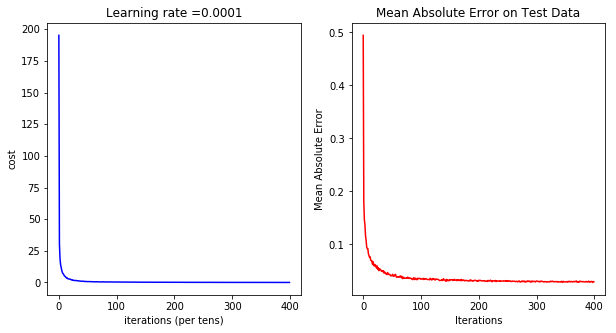

Parameters have been trained!
Final loss on train data: 0.0442586
Minimum MAE on test data: 0.0281958520867
Final MAE on test data: 0.0295846428941
Loss on test data: 0.421976
Wall time: 5min 34s


In [2754]:
%%time
#parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.001, num_epochs=6000)
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, keep_prob=0.9, num_epochs=10000)

In [2752]:
print(mean_absolute_error(labels_test.T, prediction.T))

results['NN'] = prediction.reshape(-1)

0.0249165079801


In [2760]:
results

,Target,GBM,XGB,K_Ridge,NN
0,0.246358,0.213748,0.205233,0.199551,0.247396
1,0.284106,0.247829,0.252729,0.217374,0.222097
2,0.234437,0.221621,0.228904,0.208292,0.232521
3,0.245033,0.212788,0.216041,0.219129,0.238953
4,0.079470,0.125567,0.130201,0.133720,0.124796
5,0.296026,0.287180,0.280153,0.285046,0.308292
6,0.085430,0.142741,0.149611,0.139553,0.145084
7,0.579012,0.639788,0.626779,0.510882,0.535096
8,0.178808,0.173832,0.174716,0.182496,0.188998
9,0.582781,0.491069,0.479119,0.443927,0.400604


Cost at iteration 0: 247.631973
Cost at iteration 1000: 32.562012
Cost at iteration 2000: 12.889617
Cost at iteration 3000: 6.073007
Cost at iteration 4000: 2.980466
Cost at iteration 5000: 1.644153
Cost at iteration 6000: 1.152715
Cost at iteration 7000: 1.005533
Cost at iteration 8000: 0.961800
Cost at iteration 9000: 0.943203


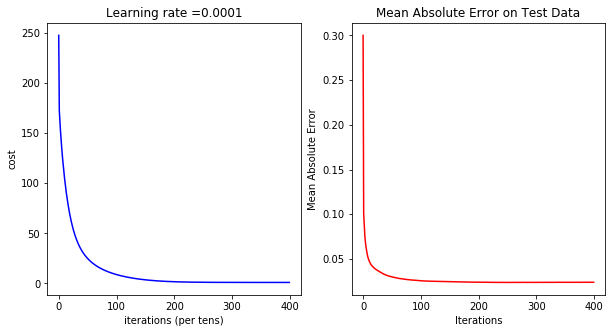

Parameters have been trained!
Final loss on train data: 0.935247
Minimum MAE on test data: 0.0237491920404
Final MAE on test data: 0.0239372634086
Loss on test data: 0.968144
Wall time: 4min 15s


In [110]:
%%time
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, lambd=1.0, num_epochs=10000)
#parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, lambd=0.00001, num_epochs=30000)

In [2769]:
labels_test[0, 18] * labels_max

79900.0

In [2777]:
train[train['Id'] == 432]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LivingAreaSF
431,432,50,RM,60.0,5586,Pave,NA,IR1,Bnk,AllPub,...,NA,MnPrv,NA,0,9,2008,ConLD,Abnorml,79900,2099


In [2780]:
tmp1 = train[(train['LivingAreaSF'] >= 2000) & (train['LivingAreaSF'] <= 2200)]
tmp1[['SaleCondition', 'SalePrice']].groupby('SaleCondition').agg([pd.np.min, pd.np.max, pd.np.mean])

SalePrice                       
                   amin    amax           mean
SaleCondition                                 
Abnorml           67000  158900  118257.066667
Alloca            89471   89471   89471.000000
Family           107000  135000  120000.000000
Normal            76500  190000  140262.439716
Partial          113000  179665  160249.571429

In [2778]:
train['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [2776]:
313.0 * 0.19169329

59.999999769999995

In [1260]:
print(mean_absolute_error(labels_test, prediction))

0.0274287305966


### Feature Engineering 1: handling features mostly correlated with target  
Как показала практика, эта штука не помогает, а наоборот: сильно ухудшает

In [201]:
fe_1_cols

[544, 564, 567, 606]

In [202]:
if (use_fe_1):
    for col in fe_1_cols:
        print("Pearson r for col", col, "is", pearsonr(features_train[:, col].reshape(-1, 1), labels_train.reshape(-1, 1))[0][0])
        
        # Train DT
        DTR = DecisionTreeRegressor(random_state=23)
        DTR.fit(features_train[:, col].reshape(-1, 1), labels_train)

        DTR_prediction1 = DTR.predict(features_train[:, col].reshape(-1, 1))
        DTR_prediction2 = DTR.predict(features_test[:, col].reshape(-1, 1))

        features_train = np.concatenate( [features_train, DTR_prediction1.reshape(-1, 1)], axis=1)
        features_test = np.concatenate( [features_test, DTR_prediction2.reshape(-1, 1)], axis=1)
        
print("New features shape is", features_train.shape)

Pearson r for col 544 is 0.59507792562
Pearson r for col 564 is 0.59725533954
Pearson r for col 567 is 0.69953753481
Pearson r for col 606 is 0.622064164667
New features shape is (1022, 679)


### Feature Selection

In [2707]:
def my_mutual_info(X, y):
    return mutual_info_regression(X, y, random_state=23)

In [2708]:
%%time

for num in list(range(10, 301, 5)):
    sel = SelectKBest(score_func=my_mutual_info, k=num)
    sel.fit(features_train, labels_train.reshape(-1))
    
    best_features_train = sel.transform(features_train)
    best_features_test = sel.transform(features_test)
    
    clf = GradientBoostingRegressor(n_estimators=250, min_samples_split=5, min_samples_leaf=2, random_state=23)
    #clf = xgboost.XGBRegressor(max_depth=4, n_estimators=300)
    
    clf.fit(best_features_train, labels_train.reshape(-1))

    prediction = clf.predict(best_features_test)

    print("Num of features:", num, "and the error:", mean_absolute_error(labels_test, prediction))

Num of features: 10 and the error: 0.0281051605919
Num of features: 15 and the error: 0.026373524992
Num of features: 20 and the error: 0.0252935764034
Num of features: 25 and the error: 0.0228834465052
Num of features: 30 and the error: 0.0228548795961
Num of features: 35 and the error: 0.0220050909192
Num of features: 40 and the error: 0.0214715726029
Num of features: 45 and the error: 0.0217378356126
Num of features: 50 and the error: 0.021290717931
Num of features: 55 and the error: 0.0219111232816
Num of features: 60 and the error: 0.0215221542437
Num of features: 65 and the error: 0.0215535434889
Num of features: 70 and the error: 0.0212812832387
Num of features: 75 and the error: 0.0215981896786
Num of features: 80 and the error: 0.0211061671218
Num of features: 85 and the error: 0.021094033704
Num of features: 90 and the error: 0.0210766351066
Num of features: 95 and the error: 0.0208754660513
Num of features: 100 and the error: 0.0205909384025
Num of features: 105 and the erro

#### Наилучший результат GBM = 0.01999 на 155 признаках  
XGB работает похуже

In [2709]:
sel = SelectKBest(score_func=my_mutual_info, k=155)
sel.fit(features_train, labels_train.reshape(-1))

best_features_train = sel.transform(features_train)
best_features_test = sel.transform(features_test)

#### Прогоним алгоритмы на сокращенном наборе и усредним

In [2710]:
results = pd.DataFrame()
results['Target'] = labels_test.reshape(-1)

In [2696]:
%%time

clf = choose_GBM(best_features_train, labels_train)

clf.fit(best_features_train, labels_train.reshape(-1))
prediction = clf.predict(best_features_test)

print(mean_absolute_error(labels_test, prediction))


-0.0234871402589
{'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 350}
0.0202941592297
Wall time: 2min 27s


In [2711]:
clf = GradientBoostingRegressor(n_estimators=250, min_samples_split=5, min_samples_leaf=2, random_state=23)
clf.fit(best_features_train, labels_train.reshape(-1))

prediction = clf.predict(best_features_test)

print(mean_absolute_error(labels_test, prediction))

results['GBM'] = prediction.reshape(-1)

0.0199961119705


In [2712]:
clf = choose_XGB(best_features_train, labels_train)

clf.fit(best_features_train, labels_train.reshape(-1))
prediction = clf.predict(best_features_test)

print(mean_absolute_error(labels_test, prediction))

results['XGB'] = prediction.reshape(-1)

-0.0240306834833
{'max_depth': 4, 'n_estimators': 300}
0.0210248258735


In [2713]:
clf = choose_KernelRidge(best_features_train, labels_train)

clf.fit(best_features_train, labels_train.reshape(-1))
prediction = clf.predict(best_features_test)

print(mean_absolute_error(labels_test, prediction))

results['K_Ridge'] = prediction.reshape(-1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.2198795484543084e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.219879548454294e-21
  ' condition number: {}'.format(rcond), RuntimeWarning)


-0.0247435408483
{'alpha': 1.0, 'gamma': 0.021544346900318832, 'kernel': 'polynomial'}
0.0249165079801


In [2717]:
average = np.mean(results[['GBM', 'K_Ridge', 'XGB']], axis=1)

print("Average vs Target", mean_absolute_error(results.Target, average))
print("GBM vs Target", mean_absolute_error(results.Target, results.GBM))

Average vs Target 0.0200525379468
GBM vs Target 0.0199961119705


#### Усреднение на сокращенном наборе признаков не даёт заметного преимущества